In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
from icedef import statoil_arcticnet_data as sd
from icedef import plot, metocean
from importlib import reload
from astroML.stats import fit_bivariate_normal, bivariate_normal
plot_dir = './plots/'

# BEACON

In [2]:
df_by_id = {}
for beacon_csv_filename in sd.beacon_csv_filenames:
    df = sd.get_beacon_df(sd.beacon_dir_path + beacon_csv_filename)
    beacon_id = df['BeaconID'][0]
    df_by_id[beacon_id] = df

In [3]:
latlons = []
labels = []

for beacon_id, df in df_by_id.items():
    lats, lons = df['Latitude'].values, df['Longitude'].values
    latlons.append([lats, lons])
    labels.append(beacon_id)

In [35]:
map_ = Basemap(projection='stere',
                  lon_0=-50,
                  lat_0=50,
                  lat_ts=50,
                  resolution='l',
                  llcrnrlon=-56,
                  llcrnrlat=46,
                  urcrnrlon=-46,
                  urcrnrlat=55,)

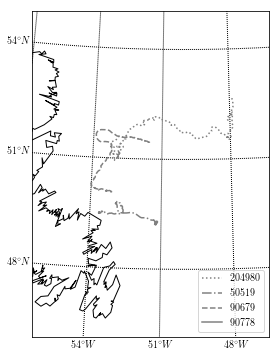

In [36]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

map_.drawcoastlines()
parallels = map_.drawparallels(np.arange(0, 90, 3), labels=[1, 0, 0, 0])
meridians = map_.drawmeridians(np.arange(0, 360, 3), labels=[0, 0, 0, 1])

for meridian in meridians:

    try:
        meridians[meridian][1][0].set_rotation(0)

    except IndexError:
        pass
    
linestyles = [':', '-.', '--', '-']

i = 0
for beacon_id, df in df_by_id.items():
    lats, lons = df['Latitude'].values, df['Longitude'].values
    x, y = map_(lons, lats)
    map_.plot(x, y, color='grey', label=beacon_id, linestyle=linestyles[i])
    i += 1

plt.legend()

fig.savefig('./plots/beacon_drift_tracks.pdf', bbox_inches='tight')

plt.show()

Initially, there were two iceberg's -- each with two beacon's attached. One iceberg, which we will call, "iceberg 1" had the beacon's: 50519 and 90778, the other, which we will call, "iceberg 2", had the beacon's 204980 and 90679. The beacon's onboard iceberg 1 were initially attached around 7 PM on April 23rd, 2015; however, after just one hour, beacon 90778 fell off leaving just beacon 50519 onboard iceberg 1 where it remained until around 2 PM on June 1st of that same year. Iceberg 2, on the other hand, has a more interesting life story. On April 24th, 2015 around 3 PM, both beacon's (204980 and 90679) were installed aboard iceberg 2. However, at around TODO, iceberg 2 split forming what we will call iceberg's 3 and 4 with beacon's 204980 and 90670; respectively. When this occurred, iceberg 2 was travelling roughly due West but after the split, iceberg 3 began moving Southwest and iceberg 4 went Northwest. Unfortunately, there is no data on the individual sizes of these bergs.

In [6]:
stats_df = pd.DataFrame(columns=['beacon_id', 'start_time', 'end_time', 'time_length', 
                                 'start_latitude', 'start_longitude',
                                 'end_latitude', 'end_longitude'])
for beacon_id, df in df_by_id.items():
    start_time = df['DataDate_UTC'][0]
    end_time = df['DataDate_UTC'][len(df['DataDate_UTC']) - 1]
    start_lat = df['Latitude'][0]
    end_lat = df['Latitude'][len(df['Latitude']) - 1]
    start_lon = df['Longitude'][0]
    end_lon = df['Longitude'][len(df['Longitude']) - 1]
    stats_df.loc[len(stats_df)] = [beacon_id, start_time, end_time, end_time - start_time, 
                                   start_lat, start_lon, end_lat, end_lon]

In [7]:
stats_df

,beacon_id,start_time,end_time,time_length,start_latitude,start_longitude,end_latitude,end_longitude
0,204980,2015-04-24 15:16:06,2015-06-13 09:33:42,49 days 18:17:36,51.45991,-51.55144,52.69404,-47.82604
1,50519,2015-04-23 18:48:37,2015-06-01 02:09:54,38 days 07:21:17,49.22403,-51.25820,49.46962,-53.58547
2,90679,2015-04-24 15:21:03,2015-05-25 01:20:03,30 days 09:59:00,51.46240,-51.55285,50.09155,-53.06512
3,90778,2015-04-23 18:53:57,2015-04-23 19:57:39,0 days 01:03:42,49.22347,-51.25890,49.22226,-51.24820


# Subset Info

In [8]:
start_time = np.datetime64(min(stats_df['start_time'])) - np.timedelta64(10, 'D')
end_time = np.datetime64(max(stats_df['end_time'])) + np.timedelta64(10, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

In [9]:
def subset_ds(ds, bounds_by_colname):
    for colname, bounds in bounds_by_colname.items():
        ds = ds.where((ds[colname] >= bounds[0]) & (ds[colname] <= bounds[1]), drop=True)
    return ds

# AVOS

In [10]:
avos_df = sd.get_avos_df()
avos_ds = sd.get_avos_ds()
avos_ds_subset = subset_ds(avos_ds, bounds_by_colname)
avos_ds_leg1 = subset_ds(avos_ds, {'time': (np.datetime64('2015-04-17'), np.datetime64('2015-05-05'))})

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


In [11]:
map_ = Basemap(projection='stere',
                  lon_0=-50,
                  lat_0=50,
                  lat_ts=50,
                  resolution='l',
                  llcrnrlon=-71,
                  llcrnrlat=43,
                  urcrnrlon=-50,
                  urcrnrlat=53,)

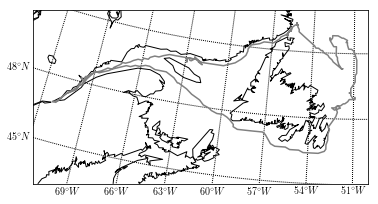

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

map_.drawcoastlines()
parallels = map_.drawparallels(np.arange(0, 90, 3), labels=[1, 0, 0, 0])
meridians = map_.drawmeridians(np.arange(0, 360, 3), labels=[0, 0, 0, 1])

for meridian in meridians:

    try:
        meridians[meridian][1][0].set_rotation(0)

    except IndexError:
        pass

lons, lats = avos_ds_leg1['longitude'].values, avos_ds_leg1['latitude'].values
x, y = map_(lons, lats)
map_.plot(x, y, color='grey')

fig.savefig('./plots/amundsen_expedition_leg1.pdf', bbox_inches='tight')

plt.show()

Note: the ship went back to port after they placed the beacons. It then stayed in port from 2015-05-05 23:00 until 2015-07-10 00:00. 

In [14]:
map_ = Basemap(projection='stere',
                  lon_0=-50,
                  lat_0=50,
                  lat_ts=50,
                  resolution='l',
                  llcrnrlon=-58,
                  llcrnrlat=44,
                  urcrnrlon=-48,
                  urcrnrlat=54,)

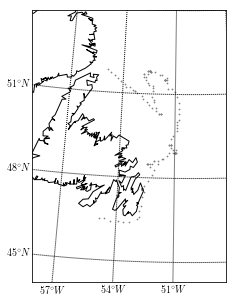

In [16]:
lons, lats = avos_ds_subset['longitude'].values, avos_ds_subset['latitude'].values

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

map_.drawcoastlines()
parallels = map_.drawparallels(np.arange(0, 90, 3), labels=[1, 0, 0, 0])
meridians = map_.drawmeridians(np.arange(0, 360, 3), labels=[0, 0, 0, 1])

for meridian in meridians:

    try:
        meridians[meridian][1][0].set_rotation(0)

    except IndexError:
        pass

x, y = map_(lons, lats)
map_.scatter(x, y, s=0.5, color='grey')

plt.gcf().subplots_adjust(bottom=0.25)

fig.savefig('./plots/avos_location.pdf', bbox_inches='tight')
plt.show()

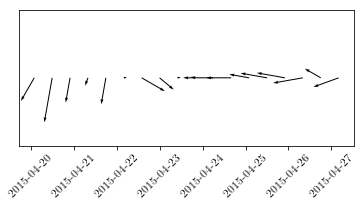

In [17]:
fig = plt.figure(figsize=(6, 3))
gap = 10
len_ = len(avos_ds_subset.time.values[::gap])
x = avos_ds_subset.time.values[::gap]
y = [0] * len_
u = avos_ds_subset.eastward_velocity.values[::gap]
v = avos_ds_subset.northward_velocity.values[::gap]
width = 3e-3
scale = 2e2
kwargs = {'width': width, 'scale': scale}
plt.quiver(x, y, u, v, **kwargs)
plt.xticks(rotation=45)
plt.yticks([])
plt.gcf().subplots_adjust(bottom=0.25)

#plt.title('AVOS Wind Velocity')
plt.show()
fig.savefig(plot_dir + 'avos_wind_velocity.pdf')

In [18]:
narr_atm = metocean.Atmosphere((avos_ds_subset.time.values[0], avos_ds_subset.time.values[-1]))

In [19]:
narr_atm_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
len_ = len(avos_ds_subset.time.values)
for i in range(len_):
    t = avos_ds_subset.time[i].values
    x = avos_ds_subset.longitude[i].values
    y = avos_ds_subset.latitude[i].values
    u = avos_ds_subset.eastward_velocity[i].values
    v = avos_ds_subset.northward_velocity[i].values
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = narr_atm.wind.interpolate((t, y, x))
                    narr_atm_df.loc[len(narr_atm_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

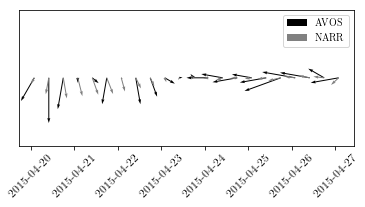

In [20]:
fig = plt.figure(figsize=(6, 3))
gap = 8
len_ = len(avos_ds_subset.time.values[::gap])
x = avos_ds_subset.time.values[::gap]
y = [0] * len_
u = avos_ds_subset.eastward_velocity.values[::gap]
v = avos_ds_subset.northward_velocity.values[::gap]
iu = narr_atm_df.iu.values[::gap]
iv = narr_atm_df.iv.values[::gap]
width = 3e-3
scale = 2e2
kwargs = {'width': width, 'scale': scale}
plt.quiver(x, y, u, v, color='black', label='AVOS', **kwargs)
plt.quiver(x, y, iu, iv, color='grey', label='NARR', **kwargs)
#plt.title('AVOS and NARR Wind Velocity')
plt.xticks(rotation=45)
plt.yticks([])
plt.legend()
plt.gcf().subplots_adjust(bottom=0.25)

plt.show()
fig.savefig(plot_dir + 'avos_narr_wind_velocity.pdf')

# ADCP

In [23]:
adcp_ds = sd.get_adcp_ds()
adcp_ds_subset = subset_ds(adcp_ds, bounds_by_colname)

In [24]:
map_ = Basemap(projection='stere',
                  lon_0=-50,
                  lat_0=50,
                  lat_ts=50,
                  resolution='l',
                  llcrnrlon=-58,
                  llcrnrlat=44,
                  urcrnrlon=-48,
                  urcrnrlat=54,)

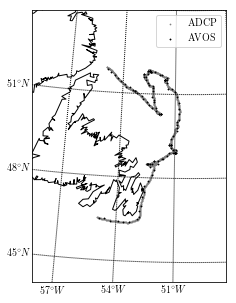

In [25]:
lons, lats = adcp_ds_subset.longitude.values, adcp_ds_subset.latitude.values

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

map_.drawcoastlines()
parallels = map_.drawparallels(np.arange(0, 90, 3), labels=[1, 0, 0, 0])
meridians = map_.drawmeridians(np.arange(0, 360, 3), labels=[0, 0, 0, 1])

for meridian in meridians:

    try:
        meridians[meridian][1][0].set_rotation(0)

    except IndexError:
        pass

x, y = map_(lons, lats)
map_.scatter(x, y, s=0.5, color='grey', label='ADCP')
lons, lats = avos_ds_subset['longitude'].values, avos_ds_subset['latitude'].values
x, y = map_(lons, lats)
map_.scatter(x, y, s=0.5, color='black', marker='D', label='AVOS')

plt.legend(loc='upper right')

plt.gcf().subplots_adjust(bottom=0.25)

fig.savefig('./plots/adcp_avos_location.pdf', bbox_inches='tight')
plt.show()

In [27]:
time_frame = adcp_ds_subset.time.values[0], adcp_ds_subset.time.values[-1]
ecmwf_ocean = metocean.Ocean(time_frame, model='ECMWF')
hycom_ocean = metocean.Ocean(time_frame, model='HYCOM')

In [28]:
ecmwf_ocean_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
hycom_ocean_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])

len_ = len(adcp_ds_subset.time.values)
for i in range(len_):
    t = adcp_ds_subset.time.values[i]
    x = adcp_ds_subset.longitude.values[i]
    y = adcp_ds_subset.latitude.values[i]
    u = adcp_ds_subset.eastward_velocity.values[i, 0]
    v = adcp_ds_subset.northward_velocity.values[i, 0]
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = ecmwf_ocean.current.interpolate((t, y, x))
                    ecmwf_ocean_df.loc[len(ecmwf_ocean_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]
                    iu, iv = hycom_ocean.current.interpolate((t, y, x))
                    hycom_ocean_df.loc[len(hycom_ocean_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

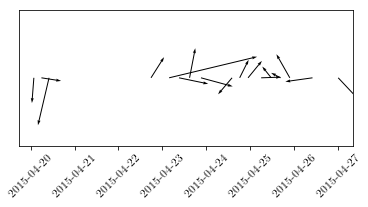

In [32]:
fig = plt.figure(figsize=(6, 3))
gap = 50
len_ = len(ecmwf_ocean_df.t.values[::gap])
x = ecmwf_ocean_df.t.values[::gap]
y = [0] * len_
u = ecmwf_ocean_df.u.values[::gap]
v = ecmwf_ocean_df.v.values[::gap]

width = 3e-3
scale = 2
kwargs = {'width': width, 'scale': scale}

plt.quiver(x, y, u, v, color='black', **kwargs)

plt.xticks(rotation=45)
plt.yticks([])
plt.gcf().subplots_adjust(bottom=0.25)
plt.show()
fig.savefig(plot_dir + 'adcp_current_velocity.pdf')

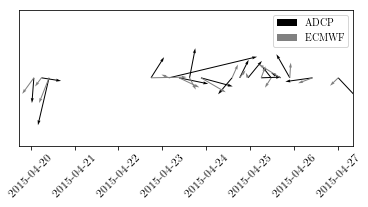

In [33]:
fig = plt.figure(figsize=(6, 3))
gap = 50
len_ = len(ecmwf_ocean_df.t.values[::gap])
x = ecmwf_ocean_df.t.values[::gap]
y = [0] * len_
u = ecmwf_ocean_df.u.values[::gap]
v = ecmwf_ocean_df.v.values[::gap]

width = 3e-3
scale = 2
kwargs = {'width': width, 'scale': scale}

plt.quiver(x, y, u, v, color='black', label='ADCP', **kwargs)
iu = ecmwf_ocean_df.iu.values[::gap]
iv = ecmwf_ocean_df.iv.values[::gap]
plt.quiver(x, y, iu, iv, color='grey', label='ECMWF', **kwargs)

plt.xticks(rotation=45)
plt.yticks([])
plt.legend()
plt.gcf().subplots_adjust(bottom=0.25)
plt.show()
fig.savefig(plot_dir + 'adcp_ecmwf_current_velocity.pdf')

# Histograms

In [25]:
class ComparativeVectorAnalysis:
    
    def __init__(self, u1, v1, u2, v2):
        
        self.u1 = u1
        self.v1 = v1
        self.u2 = u2
        self.v2 = v2
        
        self.w1 = magnitude(u1, v1)
        self.θ1 = direction(u1, v1)
        self.w2 = magnitude(u2, v2)
        self.θ2 = direction(u2, v2)
        
        self.du = self.u2 - self.u1
        self.dv = self.v2 - self.v1
        self.dw = self.w2 - self.w1
        self.dθ = self.θ2 - self.θ1
        
        self.u1_mean = mean(u1)
        self.v1_mean = mean(v1)
        self.w1_mean = mean(self.w1)
        self.θ1_mean = mean(self.θ1)
        self.u2_mean = mean(u2)
        self.v2_mean = mean(v2)
        self.w2_mean = mean(self.w2)
        self.θ2_mean = mean(self.θ2)
        
        self.u1_std = std(u1)
        self.v1_std = std(v1)
        self.w1_std = std(self.w1)
        self.θ1_std = std(self.θ1)
        self.u2_std = std(u2)
        self.v2_std = std(v2)
        self.w2_std = std(self.w2)
        self.θ2_std = std(self.θ2)
        
    def uv_stats(self):
        
        index = ['u1, u2', 'v1, v2', 'w1, w2', 'θ1, θ2']
        data = {'mean': [np.round((self.u1_mean, self.u2_mean), 3), np.round((self.v1_mean, self.v2_mean), 3), 
                         np.round((self.w1_mean, self.w2_mean), 3), np.round((self.θ1_mean, self.θ2_mean), 3)],
                'std': [np.round((self.u1_std, self.u2_std), 3), np.round((self.v1_std, self.v2_std), 3), 
                         np.round((self.w1_std, self.w2_std), 3), np.round((self.θ1_std, self.θ2_std), 3)]}
        
        return pd.DataFrame(data, index=index).T
            
    def plot_du_vs_dv(self):
        
        x = self.u2 - self.u1
        y = self.v2 - self.v1
        fit = np.polyfit(x, y, 1)
        m, b = np.round(fit, 2)
        plt.scatter(x, y)
        plt.plot(np.unique(x), np.poly1d(fit)(np.unique(x)), label=f'slope = {m}\n y-int = {b}', color='black')
        plt.xlabel('DU (m/s)')
        plt.ylabel('DV (m/s)')
        plt.title('Velocity Difference Between Datasets')
        plt.legend()
        plt.show()
        
    def plot_hists(self):
        
        u1 = self.u1
        u2 = self.u2
        v1 = self.v1
        v2 = self.v2
        
        fig = plt.figure(figsize=(6, 6))
        plt.subplot(2, 2, 1)
        plt.hist(alg1(u1, v1, u2, v2))
        plt.title('Algorithm 1 - Speed')
        plt.subplot(2, 2, 2)
        plt.hist(alg2(u1, v1, u2, v2))
        plt.title('Algorithm 2 - Speed')
        plt.subplot(2, 2, 3)
        plt.hist(alg3(u1, v1, u2, v2))
        plt.title('Algorithm 3 - Direction')
        plt.subplot(2, 2, 4)
        plt.hist(alg4(u1, v1, u2, v2))
        plt.title('Algorithm 4 - Direction')
        fig.tight_layout()
        plt.show()
        
def mean(v):
    return np.mean(v)

def std(v):
    return np.std(v)

def magnitude(u, v):
    return np.sqrt(u**2 + v**2)

def direction(u, v):
    return (np.rad2deg(np.arctan2(v, u)) + 360) % 360

def unit_vector(v):
    """ Returns the unit vector of the vector.  """
    return v / np.linalg.norm(v)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    return np.arccos(np.clip(np.dot(unit_vector(v1), unit_vector(v2)), -1.0, 1.0))

def alg1(u1, v1, u2, v2):

    w1 = np.sqrt(u1**2 + v1**2)
    w2 = np.sqrt(u2**2 + v2**2)

    return w2 - w1

def alg2(u1, v1, u2, v2):

    du = u2 - u1
    dv = v2 - v1

    return np.sqrt(du**2 + dv**2)

def alg3(u1, v1, u2, v2):

    d1 = np.rad2deg(np.arctan2(u1, v1))
    d2 = np.rad2deg(np.arctan2(u2, v2))  
    dd = 180 - abs(abs(d1 - d2) - 180)

    return dd

def alg4(u1, v1, u2, v2):

    du = u2 - u1
    dv = v2 - v1
    dd = np.arctan2(dv, du)

    return np.rad2deg(dd)

In [26]:
U1 = avos_ds_subset.eastward_velocity.values
V1 = avos_ds_subset.northward_velocity.values
U2 = narr_atm_df.iu.values
V2 = narr_atm_df.iv.values
wind_analysis = ComparativeVectorAnalysis(U1, V1, U2, V2)

In [27]:
mu, sigma_1, sigma_2, alpha = fit_bivariate_normal(U2 - U1, V2 - V1)
bivariate_normal(mu, sigma_1, sigma_2, alpha)

array([3.01368976, 0.65275589])

In [28]:
fit_bivariate_normal(U2 - U1, V2 - V1)

([4.830874416867884, 0.7319703795914418],
 6.792599938118684,
 5.317590178194657,
 -0.45788678689115525)

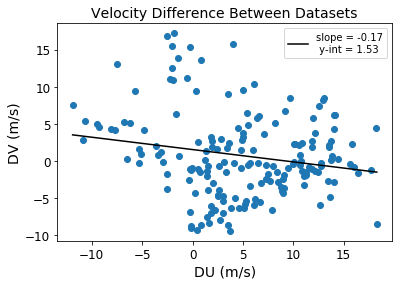

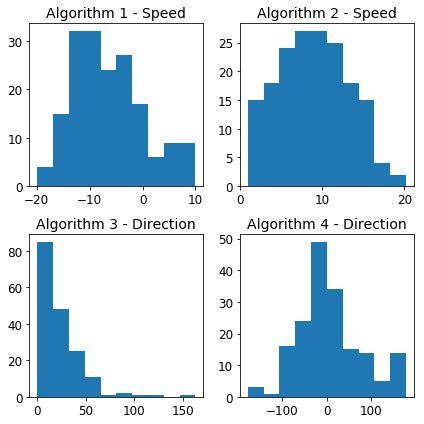

In [29]:
wind_analysis.plot_du_vs_dv()
wind_analysis.plot_hists()

In [30]:
wind_analysis.uv_stats()

,"u1, u2","v1, v2","w1, w2","θ1, θ2"
mean,"[-6.431, -1.601]","[-4.711, -3.979]","[12.8, 6.336]","[223.771, 231.604]"
std,"[9.12, 3.53]","[7.841, 4.385]","[6.662, 3.152]","[63.26, 49.584]"


In [31]:
U1 = ecmwf_ocean_df.u.values
V1 = ecmwf_ocean_df.v.values
U2 = ecmwf_ocean_df.iu.values
V2 = ecmwf_ocean_df.iv.values
current_analysis = ComparativeVectorAnalysis(U1, V1, U2, V2)

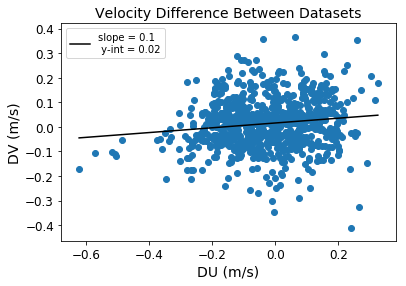

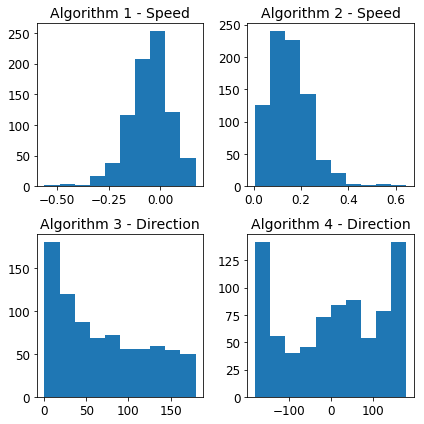

In [32]:
current_analysis.plot_du_vs_dv()
current_analysis.plot_hists()

In [33]:
current_analysis.uv_stats()

,"u1, u2","v1, v2","w1, w2","θ1, θ2"
mean,"[0.051, 0.02]","[-0.009, 0.004]","[0.16, 0.108]","[199.464, 182.823]"
std,"[0.145, 0.089]","[0.102, 0.074]","[0.093, 0.047]","[116.612, 109.95]"


In [114]:
def get_bivariate_distribution(ds, field, time_bounds, latitude_bounds, longitude_bounds, return_uv=False):
    
    bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}
    sub_ds = subset_ds(ds, bounds_by_colname)    
    df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
        
    for i in range(len(sub_ds.time.values)):
        
        t = sub_ds.time.values[i]
        x = sub_ds.longitude.values[i]
        y = sub_ds.latitude.values[i]
        
        if len(sub_ds.eastward_velocity.shape) == 2:
            u = sub_ds.eastward_velocity.values[i, 0]
            v = sub_ds.northward_velocity.values[i, 0]
            
        else:
            u = sub_ds.eastward_velocity.values[i]
            v = sub_ds.northward_velocity.values[i]
            
        if np.isfinite(u):
            if np.isfinite(v):
                iu, iv = field.interpolate((t, y, x))
                df.loc[len(df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

    U1 = df.u.values
    V1 = df.v.values
    U2 = df.iu.values
    V2 = df.iv.values
    
    fit = fit_bivariate_normal(U1 - U2, V1 - V2)
    
    if return_uv:
        return fit, [U1, V1, U2, V2]
    
    else:
        return fit

In [115]:
def plot_data_with_bivariate_distribution(distribution_c, distribution_w, UV_c, UV_w):
    
    U_c1, V_c1, U_c2, V_c2 = UV_c
    U_w1, V_w1, U_w2, V_w2 = UV_w
    
    fig = plt.figure(figsize=(10, 10))
    i = 0
    for params in [distribution_c, distribution_w]:
        ellipse1 = Ellipse(xy=params[0], width=2*params[1], height=2*params[2], angle=np.rad2deg(params[3]), 
                          alpha=0.8, edgecolor='b', lw=4, facecolor='none')
        ellipse2 = Ellipse(xy=params[0], width=2*2*params[1], height=2*2*params[2], angle=np.rad2deg(params[3]), 
                      alpha=0.8, edgecolor='b', lw=4, facecolor='none')
        if i == 0:
            ax = fig.add_subplot(121, aspect='equal')
            ax.set_title('Current Correction Distribution')
        else:
            ax = fig.add_subplot(122, aspect='equal')
            ax.set_title('Wind Correction Distribution')
        ax.axhline(y=0, color='grey')
        ax.axvline(x=0, color='grey')
        ax.scatter(*params[0], color='k', zorder=2)
        ax.annotate(s=f'{np.round(params[0], 2)}', xy=(params[0][0], params[0][1]), fontsize=14)
        if i == 0:
            ax.scatter(U_c1 - U_c2, V_c1 - V_c2, color='r')
        else:
            ax.scatter(U_w1 - U_w2, V_w1 - V_w2, color='r')
        ax.add_artist(ellipse1)
        ax.add_artist(ellipse2)
        ax.set_xlabel('dU')
        ax.set_ylabel('dV')
        i+=1

    fig.tight_layout()

In [41]:
start_time = np.datetime64(min(stats_df['start_time'])) - np.timedelta64(10, 'D')
end_time = np.datetime64(max(stats_df['start_time'])) + np.timedelta64(10, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

In [44]:
adcp_ds = sd.get_adcp_ds()
avos_ds = sd.get_avos_ds()

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:54: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


In [51]:
from icedef import test_case
tc = test_case.TestCaseB(add_timedelta=np.timedelta64(0, 'D'))

In [60]:
start_time = tc.time_frame[0] - np.timedelta64(1, 'D')
end_time = tc.time_frame[1] + np.timedelta64(1, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

current_distribution, UV_c = get_bivariate_distribution(adcp_ds, metocean.Ocean(time_bounds, model='ECMWF').current,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)

wind_distribution, UV_w = get_bivariate_distribution(avos_ds, metocean.Atmosphere(time_bounds).wind,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)
current_distribution, wind_distribution

(([-0.004259207031188701, 0.04021070540955816],
  0.1341277575544655,
  0.0985614055036261,
  0.11249854171764141),
 ([9.888013671807787, -1.1123289370532514],
  4.197132312626123,
  2.834932361995365,
  0.43084340390637416))

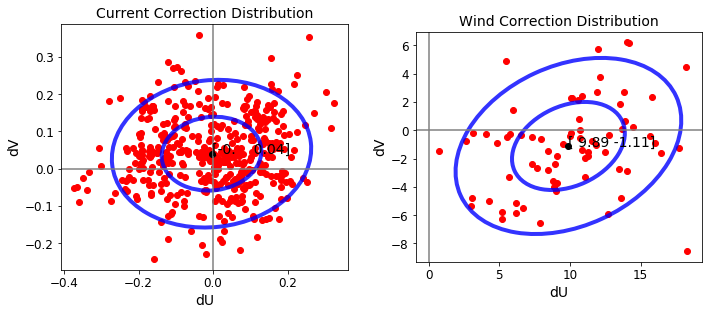

In [61]:
from matplotlib.patches import Ellipse
plot_data_with_bivariate_distribution(current_distribution, wind_distribution, UV_c, UV_w)

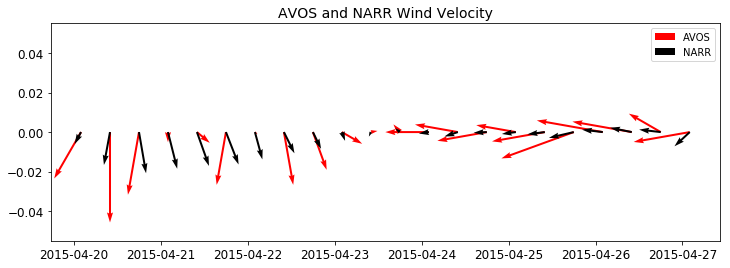

In [62]:
fig = plt.figure(figsize=(12, 4))
gap = 8
len_ = len(avos_ds_subset.time.values[::gap])
x = avos_ds_subset.time.values[::gap]
y = [0] * len_
u = avos_ds_subset.eastward_velocity.values[::gap]
v = avos_ds_subset.northward_velocity.values[::gap]
iu = narr_atm_df.iu.values[::gap]
iv = narr_atm_df.iv.values[::gap]
width = 3e-3
scale = 2e2
kwargs = {'width': width, 'scale': scale}
plt.quiver(x, y, u, v, color='red', label='AVOS', **kwargs)
plt.quiver(x, y, iu, iv, label='NARR', **kwargs)
plt.title('AVOS and NARR Wind Velocity')
plt.legend()
plt.show()
fig.savefig(plot_dir + 'avos_narr_wind_velocity.png')

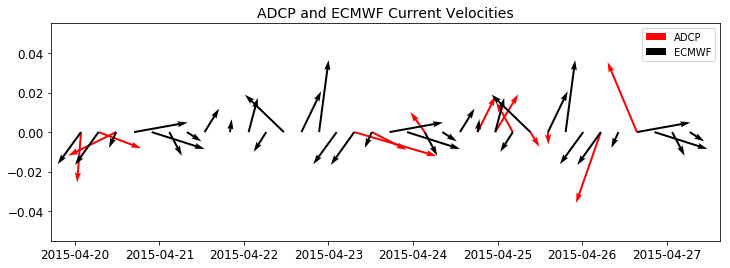

In [67]:
fig = plt.figure(figsize=(12, 4))
gap = 60
len_ = len(adcp_ds_subset.time.values[::gap])
x = adcp_ds_subset.time.values[::gap]
y = [0] * len_
u = adcp_ds_subset.eastward_velocity.values[::gap, 0]
v = adcp_ds_subset.northward_velocity.values[::gap, 0]

width = 3e-3
scale = 2
kwargs = {'width': width, 'scale': scale}

plt.quiver(x, y, u, v, color='red', label='ADCP', **kwargs)
iu = ecmwf_ocean_df.iu.values[::gap]
iv = ecmwf_ocean_df.iv.values[::gap]
plt.quiver(x, y, iu, iv, color='black', label='ECMWF', **kwargs)
#iu = hycom_ocean_df.iu.values[::gap]
#iv = hycom_ocean_df.iv.values[::gap]
#plt.quiver(x, y, iu, iv, label='HYCOM', **kwargs)
plt.title('ADCP and ECMWF Current Velocities')
plt.legend()
plt.show()
fig.savefig(plot_dir + 'ecmwf_hycom_current_velocity.png')

# New

In [78]:
start_time = stats_df.loc[stats_df['beacon_id'] == 204980]['start_time'].values[0] - np.timedelta64(1, 'D')
end_time = stats_df.loc[stats_df['beacon_id'] == 204980]['start_time'].values[0] + np.timedelta64(1, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

In [79]:
avos_df = sd.get_avos_df()
avos_ds = sd.get_avos_ds()
avos_ds_subset = subset_ds(avos_ds, bounds_by_colname)
adcp_ds = sd.get_adcp_ds()
adcp_ds_subset = subset_ds(adcp_ds, bounds_by_colname)

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:54: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


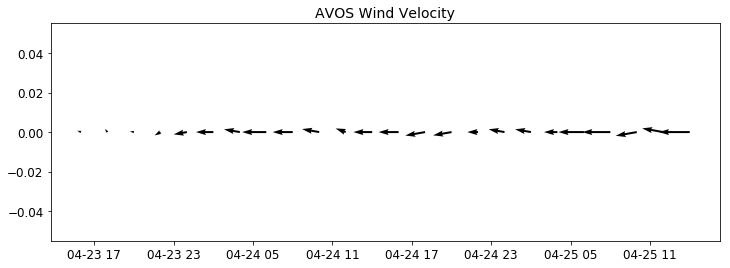

In [82]:
fig = plt.figure(figsize=(12, 4))
gap = 2
len_ = len(avos_ds_subset.time.values[::gap])
x = avos_ds_subset.time.values[::gap]
y = [0] * len_
u = avos_ds_subset.eastward_velocity.values[::gap]
v = avos_ds_subset.northward_velocity.values[::gap]
width = 3e-3
scale = 5e2
kwargs = {'width': width, 'scale': scale}
plt.quiver(x, y, u, v, **kwargs)
plt.title('AVOS Wind Velocity')
plt.show()
fig.savefig(plot_dir + 'avos_wind_velocity.png')

In [84]:
narr_atm = metocean.Atmosphere((avos_ds_subset.time.values[0], avos_ds_subset.time.values[-1]))

In [85]:
narr_atm_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
len_ = len(avos_ds_subset.time.values)
for i in range(len_):
    t = avos_ds_subset.time[i].values
    x = avos_ds_subset.longitude[i].values
    y = avos_ds_subset.latitude[i].values
    u = avos_ds_subset.eastward_velocity[i].values
    v = avos_ds_subset.northward_velocity[i].values
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = narr_atm.wind.interpolate((t, y, x))
                    narr_atm_df.loc[len(narr_atm_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

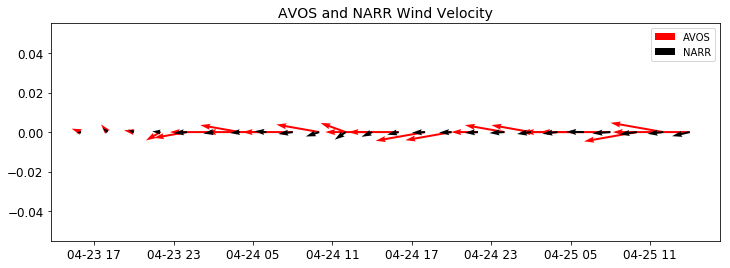

In [97]:
fig = plt.figure(figsize=(12, 4))
gap = 2
len_ = len(avos_ds_subset.time.values[::gap])
x = avos_ds_subset.time.values[::gap]
y = [0] * len_
u = avos_ds_subset.eastward_velocity.values[::gap]
v = avos_ds_subset.northward_velocity.values[::gap]
iu = narr_atm_df.iu.values[::gap]
iv = narr_atm_df.iv.values[::gap]
width = 3e-3
scale = 2e2
kwargs = {'width': width, 'scale': scale}
plt.quiver(x, y, u, v, color='red', label='AVOS', **kwargs)
plt.quiver(x, y, iu, iv, label='NARR', **kwargs)
plt.title('AVOS and NARR Wind Velocity')
plt.legend()
plt.show()
fig.savefig(plot_dir + 'avos_narr_wind_velocity.png')

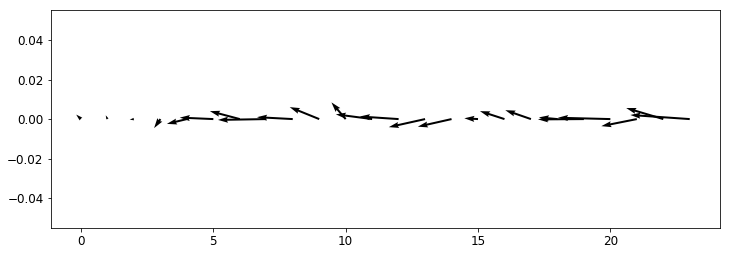

In [102]:
fig = plt.figure(figsize=(12, 4))
width = 3e-3
scale = 2e2
kwargs = {'width': width, 'scale': scale}
plt.quiver(u - iu, v - iv, **kwargs)

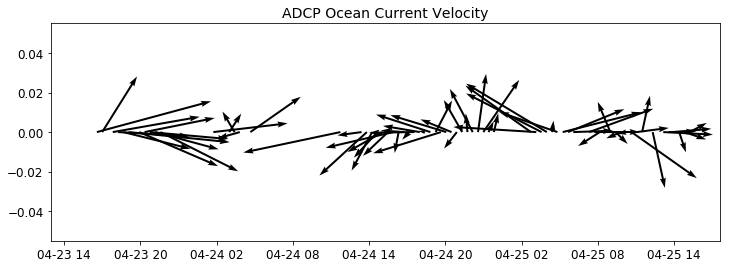

In [103]:
fig = plt.figure(figsize=(12, 4))
gap = 5
len_ = len(adcp_ds_subset.time.values[::gap])
x = adcp_ds_subset.time.values[::gap]
y = [0] * len_
u = adcp_ds_subset.eastward_velocity.values[::gap, 0] 
v = adcp_ds_subset.northward_velocity.values[::gap, 0]
width = 3e-3
scale = 2
kwargs = {'width': width, 'scale': scale}
plt.quiver(x, y, u, v, **kwargs)
plt.title('ADCP Ocean Current Velocity')
plt.show()
fig.savefig(plot_dir + 'adcp_current_velocity.png')

In [91]:
time_frame = adcp_ds_subset.time.values[0], adcp_ds_subset.time.values[-1]
ecmwf_ocean = metocean.Ocean(time_frame, model='ECMWF')
hycom_ocean = metocean.Ocean(time_frame, model='HYCOM')

In [92]:
ecmwf_ocean_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
hycom_ocean_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])

len_ = len(adcp_ds_subset.time.values)
for i in range(len_):
    t = adcp_ds_subset.time.values[i]
    x = adcp_ds_subset.longitude.values[i]
    y = adcp_ds_subset.latitude.values[i]
    u = adcp_ds_subset.eastward_velocity.values[i, 0]
    v = adcp_ds_subset.northward_velocity.values[i, 0]
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = ecmwf_ocean.current.interpolate((t, y, x))
                    ecmwf_ocean_df.loc[len(ecmwf_ocean_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]
                    iu, iv = hycom_ocean.current.interpolate((t, y, x))
                    hycom_ocean_df.loc[len(hycom_ocean_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

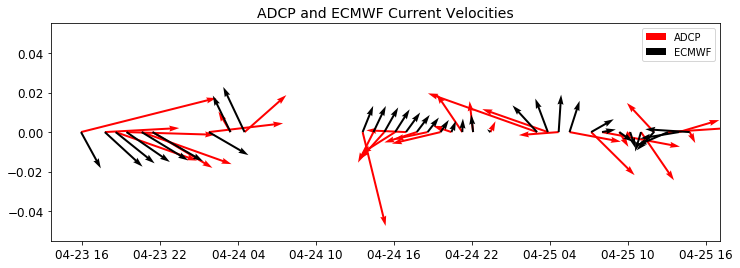

In [110]:
fig = plt.figure(figsize=(12, 4))
gap = 10
len_ = len(adcp_ds_subset.time.values[::gap])
#x = adcp_ds_subset.time.values[::gap]
#y = [0] * len_
#u = adcp_ds_subset.eastward_velocity.values[::gap, 0]
#v = adcp_ds_subset.northward_velocity.values[::gap, 0]
x = ecmwf_ocean_df.t.values[::gap]
y = [0] * len(x)
u = ecmwf_ocean_df.u.values[::gap]
v = ecmwf_ocean_df.v.values[::gap]

width = 3e-3
scale = 2
kwargs = {'width': width, 'scale': scale}

plt.quiver(x, y, u, v, color='red', label='ADCP', **kwargs)
iu = ecmwf_ocean_df.iu.values[::gap]
iv = ecmwf_ocean_df.iv.values[::gap]
plt.quiver(x, y, iu, iv, color='black', label='ECMWF', **kwargs)
#iu = hycom_ocean_df.iu.values[::gap]
#iv = hycom_ocean_df.iv.values[::gap]
#plt.quiver(x, y, iu, iv, label='HYCOM', **kwargs)
plt.title('ADCP and ECMWF Current Velocities')
plt.legend()
plt.show()
fig.savefig(plot_dir + 'ecmwf_hycom_current_velocity.png')

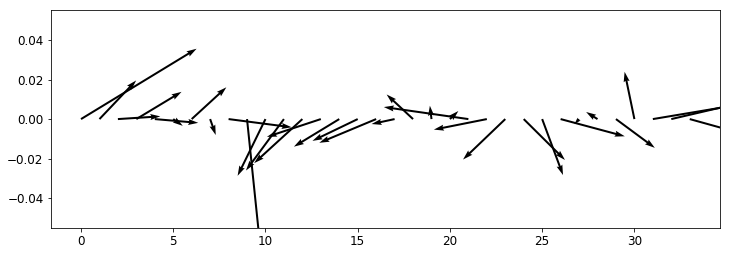

In [111]:
fig = plt.figure(figsize=(12, 4))
width = 3e-3
scale = 2
kwargs = {'width': width, 'scale': scale}
plt.quiver(u - iu, v - iv, **kwargs)

In [116]:
current_distribution, UV_c = get_bivariate_distribution(adcp_ds, metocean.Ocean(time_bounds, model='ECMWF').current,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)

wind_distribution, UV_w = get_bivariate_distribution(avos_ds, metocean.Atmosphere(time_bounds).wind,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)

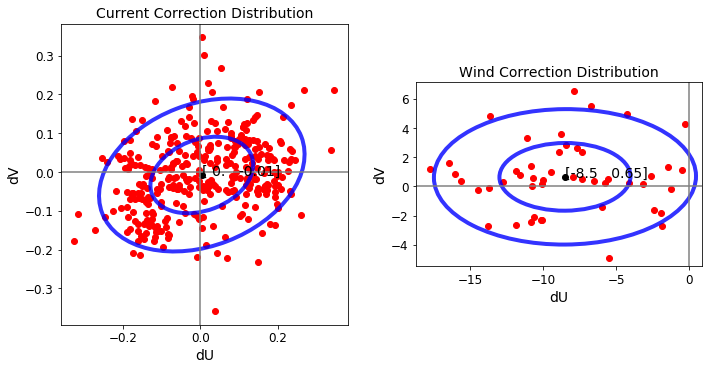

In [117]:
plot_data_with_bivariate_distribution(current_distribution, wind_distribution, UV_c, UV_w)

In [126]:
current_samples = bivariate_normal(*current_distribution, size=100000)

In [127]:
np.mean(current_samples, axis=0)

array([ 0.0034705 , -0.00803132])

In [128]:
wind_samples = bivariate_normal(*wind_distribution, size=100000)

In [129]:
np.mean(wind_samples, axis=0)

array([-8.49901458,  0.65432428])

In [132]:
# np.savetxt('/home/evankielley/new_current_correction_samples.csv', current_samples)
# np.savetxt('/home/evankielley/new_wind_correction_samples.csv', wind_samples)

In [147]:
pd.DataFrame(current_samples).to_csv('/home/evankielley/new_current_correction_samples.csv')
pd.DataFrame(wind_samples).to_csv('/home/evankielley/new_wind_correction_samples.csv')

In [143]:
current_correction_samples = pd.read_csv('/home/evankielley/new_current_correction_samples.csv')

In [3]:
from icedef import test_case

In [5]:
tc = test_case.TestCaseB()

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:54: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


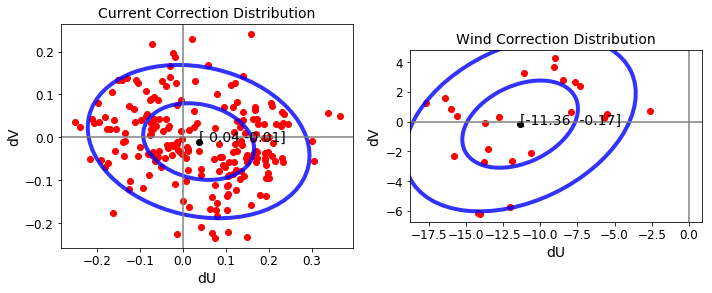

In [6]:
tc.plot_distributions()

In [7]:
avos_ds = sd.get_avos_ds()
adcp_ds = sd.get_adcp_ds()

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:54: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


In [13]:
ds = adcp_ds
lats = ds.latitude.values
lons = ds.longitude.values
times = ds.time.values

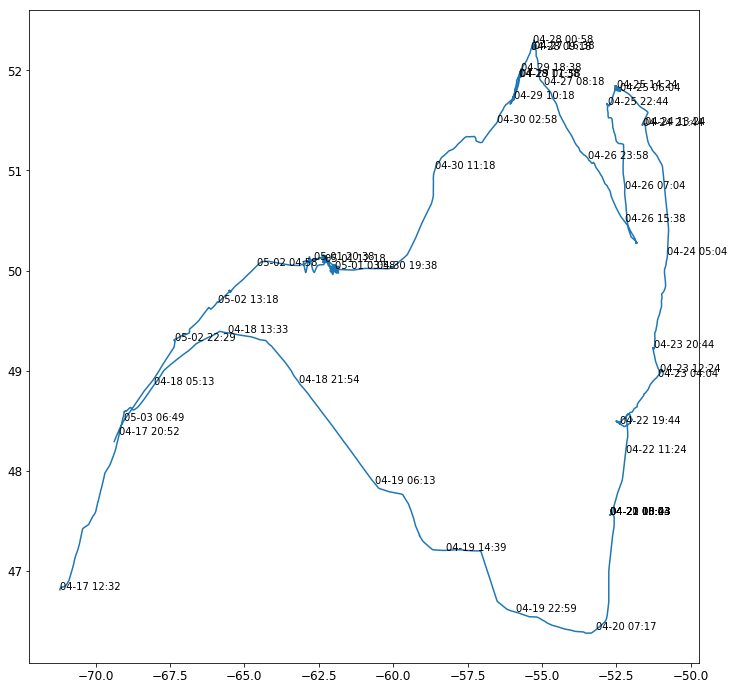

In [30]:
gap = 100

plt.figure(figsize=(12, 12))
plt.plot(lons, lats)

for time, lat, lon in zip(times[::gap], lats[::gap], lons[::gap]):
    t = pd.Timestamp(time).strftime('%m-%d %H:%M')
    if np.isfinite(lat) and np.isfinite(lon): 
        plt.annotate(s=f'{t}', xy=(lon, lat))

In [29]:
t = pd.Timestamp(time)
t.strftime('%m-%d %H:%M')

'05-03 06:49'

In [32]:
avos_ds.where(avos_ds['time'] > np.datetime64('2015-04-20'))

<xarray.Dataset>
Dimensions:             (time: 3161)
Coordinates:
  * time                (time) datetime64[ns] 2015-04-16 ... 2015-11-01T23:00:00
Data variables:
    latitude            (time) float64 nan nan nan nan ... 48.2 48.0 47.7 47.5
    longitude           (time) float64 nan nan nan nan ... -69.7 -70.0 -70.3
    direction           (time) float64 nan nan nan nan ... 30.0 10.0 40.0 50.0
    speed               (time) float64 nan nan nan nan nan ... 6.0 13.0 3.0 3.0
    air_temperature     (time) float64 nan nan nan nan nan ... 2.4 1.8 3.2 3.4
    water_temperature   (time) object nan nan nan ... '       5.0' '       5.2'
    eastward_velocity   (time) float64 nan nan nan nan ... -2.257 -1.928 -2.298
    northward_velocity  (time) float64 nan nan nan nan ... -12.8 -2.298 -1.928

In [36]:
adcp_ds.time.values[-1]

numpy.datetime64('2015-05-03T10:24:40.000000000')

In [33]:
from icedef import tools

In [39]:
bounds_by_colname = {'time': (np.datetime64('2015-04-17T12:32:17'), np.datetime64('2015-05-03T10:24:40')),
                          'longitude': (-55, -50)}
avos_dss = tools.subset_ds(avos_ds, bounds_by_colname)
adcp_dss = tools.subset_ds(adcp_ds, bounds_by_colname)
avos_dss.to_netcdf('./avos_ds.nc')
adcp_dss.to_netcdf('./adcp_ds.nc')

In [41]:
df = sd.get_beacon_df(sd.beacon_dir_path + sd.beacon_csv_filenames[1])

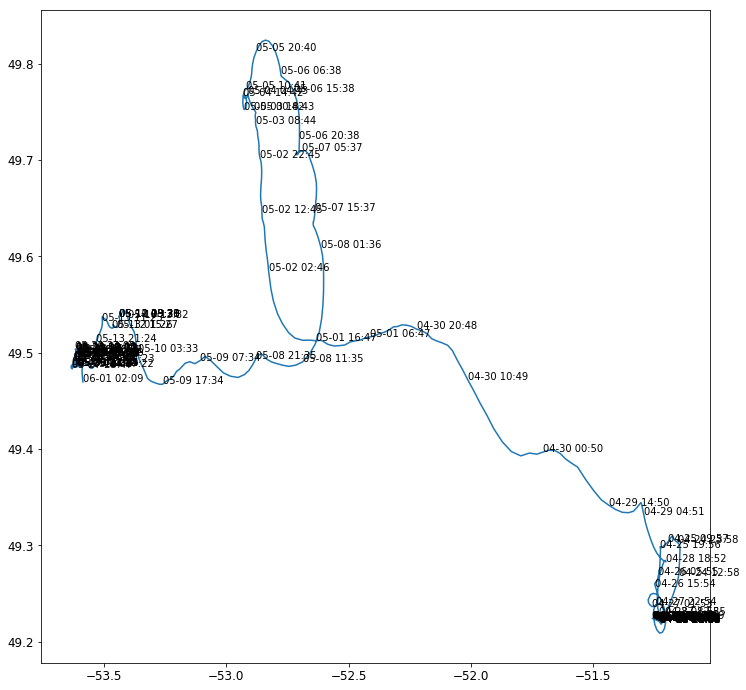

In [51]:
plt.figure(figsize=(12, 12))
plt.plot(df['Longitude'], df['Latitude'])
gap = 10
for date, lat, lon in zip(df['DataDate_UTC'].values[::gap], df['Latitude'].values[::gap], df['Longitude'].values[::gap]):
    timestamp = pd.Timestamp(date).strftime('%m-%d %H:%M')
    plt.annotate(s=f'{timestamp}', xy=(lon, lat))